# Table of Contents
- [0. Project Statement and Purpose](#0.-Project-Statement-and-Purpose)
- [1. Setup and Data Preprocessing](#1.-Setup-and-Data-Preprocessing)
    - [1.1 Importing modules and data](#1.1-Importing-modules-and-data)
    - [1.2 One-hot encoding categorical variables](#1.2-One-hot-encoding-categorical-variables)
    - [1.3 Standardising the data](#1.3-Standardising-the-data)
    - [1.4 Detecting multicollinearity in continuous variables using VIF (Variance Inflation Factor)](#1.4-Detecting-multicollinearity-in-continuous-variables-using-VIF-(Variance-Inflation-Factor))
- [2. Implementing our Bayesian Logistic Regression Model](#2.-Implementing-our-Bayesian-Logistic-Regression-Model)
    - [2.1 Model Assumptions](#2.1-Model-Assumptions)
    - [2.2 Splitting data into training and test sets](#2.2-Splitting-data-into-training-and-test-sets)
    - [2.3 Defining the priors & likelihood fn distributions](#2.3-Defining-the-priors-&-likelihood-fn-distributions)
    - [2.4 Running (Markov chain Monte Carlo) MCMC analysis to build the posterior sample](#2.4-Running-(Markov-chain-Monte-Carlo)-MCMC-analysis-to-build-the-posterior-sample)
    - [2.5 Posterior Sampling Process Diagnostics](#2.5-Posterior-Sampling-Process-Diagnostics)
    - [2.6 Adjusting our model to bias towards predicting more defaults](#2.6-Adjusting-our-model-to-bias-towards-predicting-more-defaults)
- [3. The Bayesian Models Predictions & Results](#3.-The-Bayesian-Models-Predictions-&-Results)
    - [3.1 Bayesian Model evaluated on training data](#3.1-Bayesian-Model-evaluated-on-training-data)
    - [3.2 Bayesian Model evaluated on test data](#3.2-Bayesian-Model-evaluated-on-test-data)
    - [3.3 Conclusion & summary of results](#3.3-Conclusion-&-summary-of-results)
-  [4. Acknowledgements](#4.-Acknowledgements) 

# 0. Project Statement and Purpose

**Problem Statement:** Utilise a Bayesian Logistic Regression model to help identify candidates with a low probability of default.

**About Dataset** : This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

There are 25 variables:

* **ID:** ID of each client
* **LIMIT_BAL:** Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX:** Gender (1=male, 2=female)
* **EDUCATION:** (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE:** Marital status (1=married, 2=single, 3=others)
* **AGE:** Age in years
* **PAY_0:** Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* **PAY_2:** Repayment status in August, 2005 (scale same as above)
* **PAY_3:** Repayment status in July, 2005 (scale same as above)
* **PAY_4:** Repayment status in June, 2005 (scale same as above)
* **PAY_5:** Repayment status in May, 2005 (scale same as above)
* **PAY_6:** Repayment status in April, 2005 (scale same as above)
* **BILL_AMT1:** Amount of bill statement in September, 2005 (NT dollar)
* **BILL_AMT2:** Amount of bill statement in August, 2005 (NT dollar)
* **BILL_AMT3:** Amount of bill statement in July, 2005 (NT dollar)
* **BILL_AMT4:** Amount of bill statement in June, 2005 (NT dollar)
* **BILL_AMT5:** Amount of bill statement in May, 2005 (NT dollar)
* **BILL_AMT6:** Amount of bill statement in April, 2005 (NT dollar)
* **PAY_AMT1:** Amount of previous payment in September, 2005 (NT dollar)
* **PAY_AMT2:** Amount of previous payment in August, 2005 (NT dollar)
* **PAY_AMT3:** Amount of previous payment in July, 2005 (NT dollar)
* **PAY_AMT4:** Amount of previous payment in June, 2005 (NT dollar)
* **PAY_AMT5:** Amount of previous payment in May, 2005 (NT dollar)
* **PAY_AMT6:** Amount of previous payment in April, 2005 (NT dollar)
* **default.payment.next.month:** Default payment (1=yes, 0=no)


# 1. Setup and Data Preprocessing

### 1.1 Importing modules and data

**First let me import all relevant modules used in this project.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import pymc3 as pm
import arviz as az
import pickle # for saving our model results locally
import xarray as xr
import theano
import theano.tensor as tt

**Next I import the file as a dataframe.**

In [2]:
# importing the country data csv file
file = "UCI_Credit_Card.csv"
data = pd.read_csv(file)

# setting to display all our columns
pd.set_option('display.max_columns', None)
# display first 5 rows to get a sense of the data
display(data.head())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**I perform a quick check for any missing values in the dataset. Thankfully, none to worry about.**

In [3]:
missing_values = data.isnull().sum()
display(missing_values)

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

**There is also no duplicate data to worry about.**

In [4]:
print(f"Number of duplicate rows: {data.duplicated().sum()}")
display = data.drop_duplicates()

Number of duplicate rows: 0


**Next I explore the data to get an idea of its distribution and characteristics. I do this by iterating through each numerical column and displaying a freq dist. You can run the below code to check but I choose not to display the output due to its length.**

In [ ]:
# focusing on numerical columns 
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    print(f"Distribution for {column}:")
    distribution = data[column].value_counts().sort_index()
    print(distribution)
    print("\n" + "-"*50 + "\n")

**The code below helps me one-hot encode my categorical variables into several binary variables. This helps with intepreting the model that we will eventually build**

<u>These are the "new" binary variables:</u>

- male: 1 if individual is male, 0 else  
- high_school: 1 if individual went to high school, 0 else   
- university: 1 if individual went to uni, 0 else   
- other_education: 1 if individual is in "other education" category, 0 else    
- unknown_education_one: 1 if individual is in "first unknown education" category, 0 else    
- unknown_education_two: 1 if individual is in "second unknown education" category, 0 else  
- married: 1 if individual is married, 0 else   
- others: 1 if individual is under "others" marriage status, 0 else   

Note, we "drop" some variables during one-shot encoding process. Namely:
- there is no "female" category for females
- there is no "graduate" category for people who attended graduate school
- there is no "singles" category for people who are not married

**Why is this the case?** Given the nature of categorical data, the information is still imbedded in our data. For example, if for some individual male=0 then we know this individual must be a female. In fact, including the variables adds the same information twice and introduces problems like the dummy variable trap.

**Does our intepretation change?** Yes. We now use the dropped out variables for the basis of our intepretation. For example, if I run a regression on the one-shot encode variable "male" and find it has a positive coefficient the intepretation is no longer "being male has a positive impact on default rates" but rather "being male has a positive impact vs being female, on default rates".

### 1.2 One-hot encoding categorical variables

In [5]:
# for SEX, using female as the dummy, we create a column for male
data['male'] = (data['SEX'] == 1).astype(int)

# for EDUCATION, letting grad school be the dummy, we create columns for high school, university, and unknown/other education variables
data['high_school'] = (data['EDUCATION'] == 3).astype(int)
data['university'] = (data['EDUCATION'] == 2).astype(int)
data['other_education'] = (data['EDUCATION'] == 4).astype(int)
data['unknown_education_one'] = (data['EDUCATION'] == 5).astype(int)
data['unknown_education_two'] = (data['EDUCATION'] == 6).astype(int)


# for MARRIAGE, letting singles be the dummy, we create columns for married and others
data['married'] = (data['MARRIAGE'] == 1).astype(int)
data['other_marriage_status'] = (data['MARRIAGE'] == 3).astype(int)

data.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,male,high_school,university,other_education,unknown_education_one,unknown_education_two,married,other_marriage_status
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,1,0
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,0,0,1,0,0,0,0,0
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,0,1,0,0,0,0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,0,1,0,0,0,1,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,1,0,1,0,0,0,1,0


### 1.3 Standardising the data

**I create a dataframe with standardised data (mean=0, s.d.=1) for later usage in our Bayesian modelling.**

In [6]:
# create new df for standardised data
data_std = data.copy(deep=True)

# I standardize the continuous variables only. Binary variables are left unchanged.
continuous_vars = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
scaler = StandardScaler()
data_std[continuous_vars] = scaler.fit_transform(data_std[continuous_vars])

data_std.head(5)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,male,high_school,university,other_education,unknown_education_one,unknown_education_two,married,other_marriage_status
0,1,-1.136720,2,2,1,-1.246020,2,2,-1,-1,-2,-2,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1,0,0,1,0,0,0,1,0
1,2,-0.365981,2,2,2,-1.029047,-1,2,0,0,0,2,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1,0,0,1,0,0,0,0,0
2,3,-0.597202,2,2,2,-0.161156,0,0,0,0,0,0,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0,0,0,1,0,0,0,0,0
3,4,-0.905498,2,2,1,0.164303,0,0,0,0,0,0,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0,0,0,1,0,0,0,1,0
4,5,-0.905498,1,2,1,2.334029,-1,0,-1,0,0,0,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0,1,0,1,0,0,0,1,0


### 1.4 Detecting multicollinearity in continuous variables using VIF (Variance Inflation Factor)

In [7]:
# predictors only
predictors = data_std.drop(columns=['ID', 'default.payment.next.month', 'male', 'high_school', 
                                    'university', 'other_education', 'unknown_education_one', 'unknown_education_two', 'married', 'other_marriage_status',
                                   'SEX','EDUCATION', 'MARRIAGE'])

# adding constant term to variables
X = add_constant(predictors)

# calculating VIF for each variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

     Variable        VIF
0       const   1.099202
1   LIMIT_BAL   1.474736
2         AGE   1.022883
3       PAY_0   1.919441
4       PAY_2   3.170914
5       PAY_3   3.656924
6       PAY_4   4.286762
7       PAY_5   4.724273
8       PAY_6   3.255010
9   BILL_AMT1  14.016624
10  BILL_AMT2  25.861659
11  BILL_AMT3  21.771479
12  BILL_AMT4  20.346083
13  BILL_AMT5  24.990458
14  BILL_AMT6  15.024145
15   PAY_AMT1   1.707835
16   PAY_AMT2   2.236865
17   PAY_AMT3   1.756551
18   PAY_AMT4   1.648438
19   PAY_AMT5   1.687563
20   PAY_AMT6   1.169891


**note: as a rule of thumb values >5 signals multi-collinearity.**

- BILL_AMT variables clearly are a worry
- and while less than 5, PAY_ variables are also elevated

**Due to the high multicollinearity, I introduce a new variable BILL_AMT_average which is simply the average of the 6 variables.**

In [8]:
# averaging BILL_AMTs & create 'BILL_AMT_average' column
predictors['BILL_AMT_average'] = predictors[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
new_predictors = predictors.drop(columns=['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'])
data_std['BILL_AMT_average'] = new_predictors['BILL_AMT_average'] 

**It can also be shown by running a simple logistic regression on the variables above, that the "later" PAY_ variables have a much less significant impact on the probability of default (by p-value measures). I opt to introduce a PAY_weighted term which combines the "older" data into one variable. This has two main benefits of (i) having a more statistically significant impact on default & (ii) reducing multicollinearity according to VIF measures.**

In [9]:
data_std['PAY_weighted'] = (data_std['PAY_4'] * 3 + data_std['PAY_5'] * 2 + data_std['PAY_6']) / 6
new_predictors.drop(columns=['PAY_4', 'PAY_5', 'PAY_6'], inplace=True)
new_predictors['PAY_weighted'] = data_std['PAY_weighted']
new_predictors

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT_average,PAY_weighted
0,-1.136720,-1.246020,2,2,-1,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,-0.657696,-1.500000
1,-0.365981,-1.029047,-1,2,0,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,-0.631842,0.333333
2,-0.597202,-0.161156,0,0,0,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,-0.422236,0.000000
3,-0.905498,0.164303,0,0,0,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,-0.102270,0.000000
4,-0.905498,2.334029,-1,0,-1,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,-0.396290,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.404759,0.381275,0,0,0,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130,1.062838,0.000000
29996,-0.134759,0.815221,-1,-1,-1,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382,-0.621476,-0.500000
29997,-1.059646,0.164303,4,3,2,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001,-0.488230,-0.500000
29998,-0.674276,0.598248,1,-1,0,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904,-0.006071,-0.166667


**Notice that following our modifications, VIF values are much lower and all <5:**

In [10]:
X = add_constant(new_predictors)

# calc VIF for each variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

            Variable       VIF
0              const  1.081776
1          LIMIT_BAL  1.466067
2                AGE  1.022468
3              PAY_0  1.918152
4              PAY_2  3.139681
5              PAY_3  3.484177
6           PAY_AMT1  1.215937
7           PAY_AMT2  1.181997
8           PAY_AMT3  1.173798
9           PAY_AMT4  1.127795
10          PAY_AMT5  1.109300
11          PAY_AMT6  1.107979
12  BILL_AMT_average  1.451467
13      PAY_weighted  2.764620


# 2. Implementing our Bayesian Logistic Regression Model

### 2.1 Model Assumptions

Checking that assumptions for bayes logistic regression hold

1. **linear relationship between X and log y:** this is demonstrated by running a logistic regression on our X and y variables below and noting "significance" of coefficients.
2. **assume prior distributions over coefficients represent our prior beliefs accurately:** we pick priors to satisfy this condition.
3. **assume our likelihood p(y|x,b) follows a Bernoulli distribution:** default is binary, so can be correctly modelled by bernoulli distribution.

In [11]:
x_vars = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_weighted',
          'BILL_AMT_average', 'male', 'married', 'other_marriage_status',
          'high_school', 'other_education', 'unknown_education_one',
          'unknown_education_two', 'university', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
y_var = 'default.payment.next.month'

for var in x_vars:
    # fit logistic model
    X = sm.add_constant(data_std[var])  # adding a constant
    model = sm.Logit(data_std[y_var], X)
    result = model.fit(disp=0)  # disp=0 to suppress fit output
    
    # print the summary
    print(f'Regression Results for {var}:\n')
    print(result.summary())
    print("\n")


Regression Results for LIMIT_BAL:

                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29998
Method:                                   MLE   Df Model:                            1
Date:                        Fri, 10 May 2024   Pseudo R-squ.:                 0.02441
Time:                                15:19:22   Log-Likelihood:                -15466.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                2.347e-170
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3086      0.015    -89.855      0.000      -1.337      -1.280
LIMIT_BAL     -0.4284      0.016

**Frequentist Logistic Regression Results:**

In [12]:
X = sm.add_constant(data_std[x_vars])  # include all predictors
model = sm.Logit(data_std[y_var], X)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.464612
         Iterations 7
                               Logit Regression Results                               
Dep. Variable:     default.payment.next.month   No. Observations:                30000
Model:                                  Logit   Df Residuals:                    29978
Method:                                   MLE   Df Model:                           21
Date:                        Fri, 10 May 2024   Pseudo R-squ.:                  0.1208
Time:                                15:19:24   Log-Likelihood:                -13938.
converged:                               True   LL-Null:                       -15853.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 

**As you can see p<0.05 for majority of variables suggests assumption 1 (linearity between X and log y) holds.**

### 2.2 Splitting data into training and test sets

In [13]:
X = data_std.drop(['default.payment.next.month', 'ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_4' , 
                   'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
 'BILL_AMT5', 'BILL_AMT6'], axis=1)  # or any other target column name
y = data_std['default.payment.next.month']

# data split: (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.3 Defining the priors & likelihood fn distributions

**We utilise our logistic regression results and general knowledge to better set-up our priors, some examples:**
- Introducing directionality bias for variables we know have certain positive or negative correlation with default. 
- Greater/lower sigma for variables with greater/lesser relevance or significance to help model explore specific parmater more/less.
- "Shrinkage" priors by setting low sigma (e.g. = 0.15) for variables with low statistically significant impact on default variable.

In [14]:
# define model within a PyMC context
shared_X = theano.shared(X_train.values)  # initialise model with training set, X_train

with pm.Model() as model:
    # priors for each coefficient of your variables
    beta_LIMIT_BAL = pm.Normal('beta_LIMIT_BAL', mu=-0.05, sigma=1)  
    beta_AGE = pm.Normal('beta_AGE', mu=0.05, sigma=1)  
    beta_PAY_0 = pm.Normal('beta_PAY_0', mu=0.05, sigma=2)  
    beta_PAY_2 = pm.Normal('beta_PAY_2', mu=0.05, sigma=1) 
    beta_PAY_3 = pm.Normal('beta_PAY_3', mu=0.05, sigma=1)  
    beta_PAY_weighted = pm.Normal('beta_PAY_weighted', mu=0, sigma=1)  
    beta_BILL_AMT_average = pm.Normal('beta_BILL_AMT_average', mu=-0.05, sigma=1)  
    beta_male = pm.Normal('beta_male', mu=0.05, sigma=1)  
    beta_married = pm.Normal('beta_married', mu=0.05, sigma=1) 
    beta_other_marriage_status = pm.Normal('beta_other_marriage_status', mu=0, sigma=0.15)  
    beta_high_school = pm.Normal('beta_high_school', mu=-0.05, sigma=1) 
    beta_other_education = pm.Normal('beta_other_education', mu=0, sigma=1)  
    beta_unknown_education_one = pm.Normal('beta_unknown_education_one', mu=0, sigma=1)  
    beta_unknown_education_two = pm.Normal('beta_unknown_education_two', mu=0, sigma=0.15)  
    beta_university = pm.Normal('beta_university', mu=-0.05, sigma=1) 
    
    # adding priors for the payment amount variables
    beta_PAY_AMT1 = pm.Normal('beta_PAY_AMT1', mu=-0.05, sigma=2)  
    beta_PAY_AMT2 = pm.Normal('beta_PAY_AMT2', mu=-0.05, sigma=2)  
    beta_PAY_AMT3 = pm.Normal('beta_PAY_AMT3', mu=-0.05, sigma=1)  
    beta_PAY_AMT4 = pm.Normal('beta_PAY_AMT4', mu=-0.05, sigma=1)  
    beta_PAY_AMT5 = pm.Normal('beta_PAY_AMT5', mu=-0.05, sigma=0.5)  
    beta_PAY_AMT6 = pm.Normal('beta_PAY_AMT6', mu=-0.05, sigma=0.5)  

    # linear model expression using training data
    linear_expression = (beta_LIMIT_BAL * X_train['LIMIT_BAL'] +
                         beta_AGE * X_train['AGE'] +
                         beta_PAY_0 * X_train['PAY_0'] +
                         beta_PAY_2 * X_train['PAY_2'] +
                         beta_PAY_3 * X_train['PAY_3'] +
                         beta_PAY_weighted * X_train['PAY_weighted'] +
                         beta_BILL_AMT_average * X_train['BILL_AMT_average'] +
                         beta_male * X_train['male'] +
                         beta_married * X_train['married'] +
                         beta_other_marriage_status * X_train['other_marriage_status'] +
                         beta_high_school * X_train['high_school'] +
                         beta_other_education * X_train['other_education'] +
                         beta_unknown_education_one * X_train['unknown_education_one'] +
                         beta_unknown_education_two * X_train['unknown_education_two'] +
                         beta_university * X_train['university'] +
                         beta_PAY_AMT1 * X_train['PAY_AMT1'] +
                         beta_PAY_AMT2 * X_train['PAY_AMT2'] +
                         beta_PAY_AMT3 * X_train['PAY_AMT3'] +
                         beta_PAY_AMT4 * X_train['PAY_AMT4'] +
                         beta_PAY_AMT5 * X_train['PAY_AMT5'] +
                         beta_PAY_AMT6 * X_train['PAY_AMT6'])

    # likelihood (sampling distribution) of observations using training data
    likelihood = pm.Bernoulli('likelihood', p=pm.math.sigmoid(linear_expression), observed=y_train)

### 2.4 Running (Markov chain Monte Carlo) MCMC analysis to build the posterior sample

In [15]:
with model:
    trace = pm.sample(5000)  # sampling from the posterior 5000 times, default = 4 chains


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_PAY_AMT6, beta_PAY_AMT5, beta_PAY_AMT4, beta_PAY_AMT3, beta_PAY_AMT2, beta_PAY_AMT1, beta_university, beta_unknown_education_two, beta_unknown_education_one, beta_other_education, beta_high_school, beta_other_marriage_status, beta_married, beta_male, beta_BILL_AMT_average, beta_PAY_weighted, beta_PAY_3, beta_PAY_2, beta_PAY_0, beta_AGE, beta_LIMIT_BAL]
Sampling 4 chains, 0 divergences: 100%|█| 22000/22000 [01:59<00:00, 184.44draws/


In [16]:
# optional code to save code locally
# save the model and trace using pickle
with open('model_and_trace.pkl', 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

In [ ]:
# optional code to load code locally 
# load the model and trace using pickle
with open('model_and_trace.pkl', 'rb') as buff:
    data = pickle.load(buff)

model = data['model']
trace = data['trace']

inference_data = az.from_pymc3(trace)


The below code converts the output of a PyMC3 model sampling (stored in trace) into an Inference Data object for easier use with later code:

In [17]:
inference_data = az.from_pymc3(trace)

/Users/evgenigeorgiev/anaconda3/envs/fplenv/lib/python3.10/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


### 2.5 Posterior Sampling Process Diagnostics

**Plotting density and trace plots**
- smooth & unimodal density plots resembling normal distributions suggest good convergence to the true posterior distributions
- "hairy caterpillar" around a stable mean value with mixing/switching suggests good exploration for our posteriors

/Users/evgenigeorgiev/anaconda3/envs/fplenv/lib/python3.10/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta_LIMIT_BAL'}>,
        <Axes: title={'center': 'beta_LIMIT_BAL'}>],
       [<Axes: title={'center': 'beta_AGE'}>,
        <Axes: title={'center': 'beta_AGE'}>],
       [<Axes: title={'center': 'beta_PAY_0'}>,
        <Axes: title={'center': 'beta_PAY_0'}>],
       [<Axes: title={'center': 'beta_PAY_2'}>,
        <Axes: title={'center': 'beta_PAY_2'}>],
       [<Axes: title={'center': 'beta_PAY_3'}>,
        <Axes: title={'center': 'beta_PAY_3'}>],
       [<Axes: title={'center': 'beta_PAY_weighted'}>,
        <Axes: title={'center': 'beta_PAY_weighted'}>],
       [<Axes: title={'center': 'beta_BILL_AMT_average'}>,
        <Axes: title={'center': 'beta_BILL_AMT_average'}>],
       [<Axes: title={'center': 'beta_male'}>,
        <Axes: title={'center': 'beta_male'}>],
       [<Axes: title={'center': 'beta_married'}>,
        <Axes: title={'center': 'beta_married'}>],
       [<Axes: title={'center': 'beta_other_marriage_status'}>,
        <Axes: title=

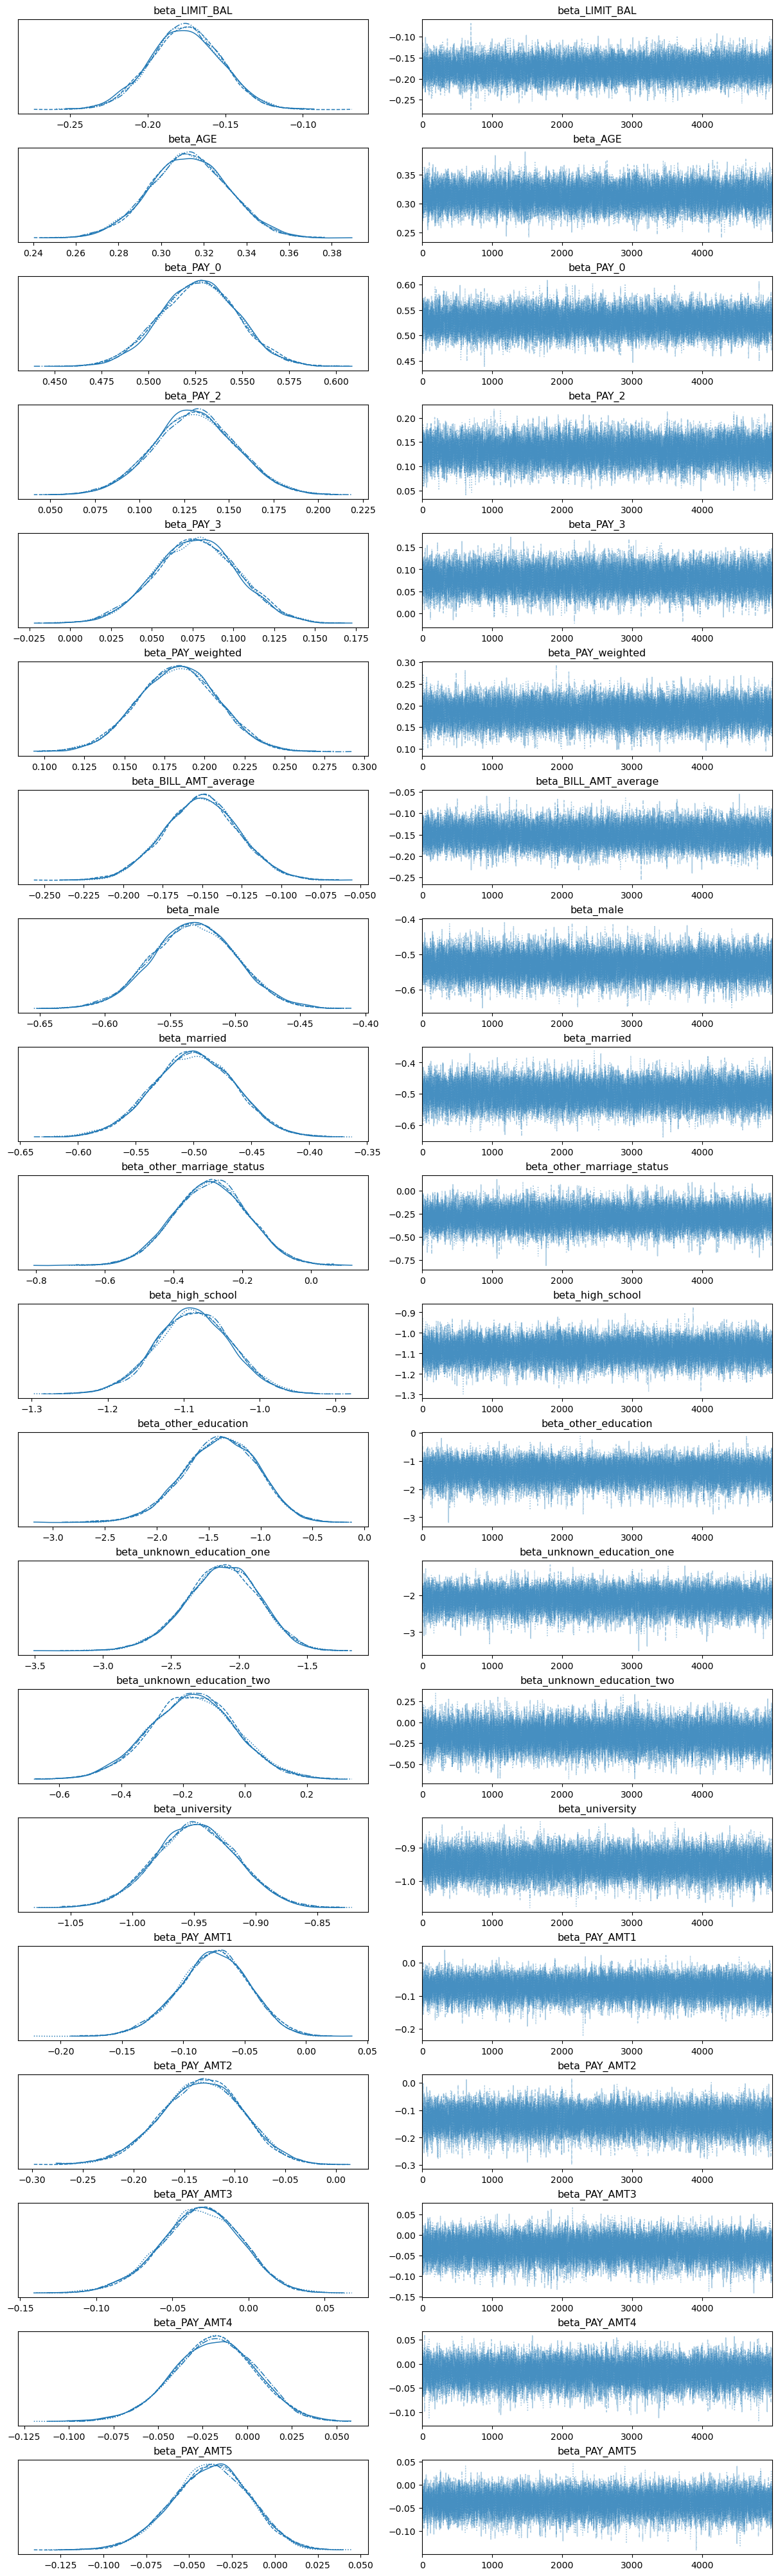

In [18]:
pm.traceplot(trace)

**Gelman-Rubin (Rhat) diagnostics:**
- Rhat <1.1 for all variables suggests good convergence of the 4 markov chains to common distribution.

In [19]:
xr.set_options(display_width=200, display_max_rows=21)  # Adjust as necessary for your dataset

gelman_rubin = az.rhat(inference_data)
print("Gelman-Rubin Diagnostic:\n", gelman_rubin)


Gelman-Rubin Diagnostic:
 <xarray.Dataset>
Dimensions:                     ()
Data variables:
    beta_LIMIT_BAL              float64 1.0
    beta_AGE                    float64 1.001
    beta_PAY_0                  float64 1.0
    beta_PAY_2                  float64 1.0
    beta_PAY_3                  float64 1.0
    beta_PAY_weighted           float64 1.0
    beta_BILL_AMT_average       float64 0.9999
    beta_male                   float64 1.0
    beta_married                float64 1.0
    beta_other_marriage_status  float64 0.9999
    beta_high_school            float64 1.0
    beta_other_education        float64 1.0
    beta_unknown_education_one  float64 1.0
    beta_unknown_education_two  float64 1.0
    beta_university             float64 1.0
    beta_PAY_AMT1               float64 1.0
    beta_PAY_AMT2               float64 1.0
    beta_PAY_AMT3               float64 1.0
    beta_PAY_AMT4               float64 1.0
    beta_PAY_AMT5               float64 1.0
    beta_PAY_AMT6 

**Effective Sample Size (ESS):**

- High ESS values suggest lower autocorrelation between samples implying more unique information in each sample.
- Suggests sampling process explored paramater space well.

In [20]:
# Eeffective Sample Size
ess = az.ess(inference_data)
print("Effective Sample Size:\n", ess)


Effective Sample Size:
 <xarray.Dataset>
Dimensions:                     ()
Data variables:
    beta_LIMIT_BAL              float64 2.024e+04
    beta_AGE                    float64 2.057e+04
    beta_PAY_0                  float64 2.077e+04
    beta_PAY_2                  float64 1.884e+04
    beta_PAY_3                  float64 1.769e+04
    beta_PAY_weighted           float64 1.931e+04
    beta_BILL_AMT_average       float64 1.966e+04
    beta_male                   float64 2.886e+04
    beta_married                float64 1.55e+04
    beta_other_marriage_status  float64 2.583e+04
    beta_high_school            float64 1.887e+04
    beta_other_education        float64 2.229e+04
    beta_unknown_education_one  float64 2.257e+04
    beta_unknown_education_two  float64 2.819e+04
    beta_university             float64 1.544e+04
    beta_PAY_AMT1               float64 2.331e+04
    beta_PAY_AMT2               float64 2.385e+04
    beta_PAY_AMT3               float64 2.63e+04
    beta_P

**Posterior predictive checks (PPC)**

We use our posterior samples to fit our Bayesian Log Regression and predict values of y (yhat). In PPC we plot the distribution of our predictions vs the actual observed y's.

In [21]:
with model:
    # drawing posterior predictive samples
    ppc = pm.sample_posterior_predictive(trace, model=model, var_names=['likelihood'])

100%|████████████████████████████████████| 20000/20000 [00:35<00:00, 561.69it/s]


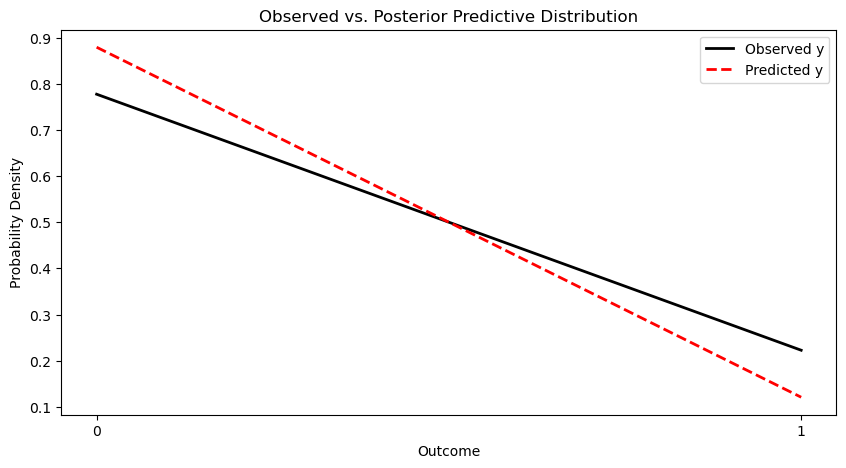

In [22]:
# extracting the mean probability to decide class 0 or 1
y_hat = (ppc['likelihood'] > 0.5).astype(int)

# the observed y values from the training data
observed_y = y_train

# calculating histogram data for plotting
observed_counts, bins = np.histogram(observed_y, bins=[-0.5, 0.5, 1.5], density=True)
predicted_counts = np.histogram(y_hat.mean(axis=0), bins=[-0.5, 0.5, 1.5], density=True)[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # centers of bins

plt.figure(figsize=(10, 5))
plt.plot(bin_centers, observed_counts, 'k-', linewidth=2, label='Observed y')
plt.plot(bin_centers, predicted_counts, 'r--', linewidth=2, label='Predicted y')

plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Outcome')
plt.ylabel('Probability Density')
plt.title('Observed vs. Posterior Predictive Distribution')
plt.legend()
plt.show()


**Our Bayesian Logistic Model has a bias towards predicting non-default:** this is a problem as in a business setting it can lead to giving out too many loans to non-credit worthy customers.

### 2.6 Adjusting our model to bias towards predicting more defaults

**In order to combat the issue of under-predicting default, we can adjust the threshold to bias the model towards predicting default much more often. This leaves us with:**
1. a very conservative model that predicts default in the majority of cases.
2. a very high recall approx 92%. In other words, if the model predicts a consumer will <u>not</u> default, then we can be sure with approx. 92% confidence in its prediction.
3. a low accuracy (33%) since the model is very conservatively predicting most consumers will default.

Clearly there is room for improvement in terms of efficiency. If a business was to use this model, they would be giving up on a lot of potential business opportunities due to the high rejection rates for a loan. But for a conservative business, that has risk mitigation (not profit maximisation) as a primary concern, this model could be interesting.

/Users/evgenigeorgiev/anaconda3/envs/fplenv/lib/python3.10/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|█████████████████████████████████████| 5000/5000 [00:04<00:00, 1023.09it/s]


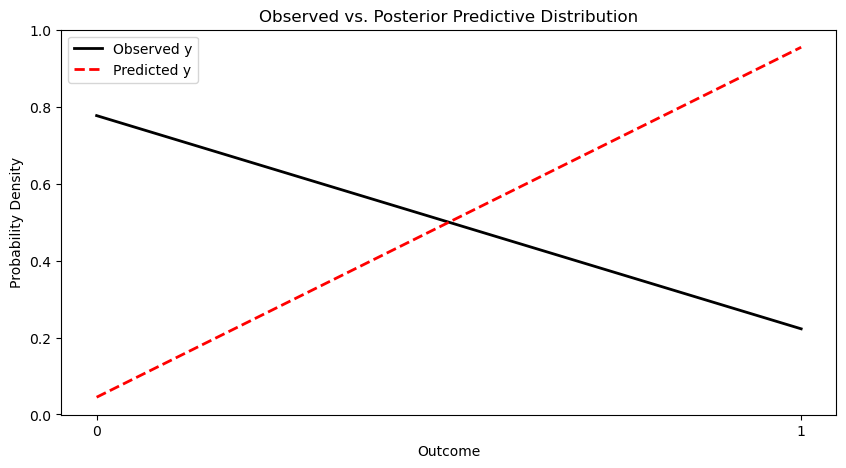

In [24]:

model = pm.Model()
with model:
    # define your priors, likelihood, and any transformations
    if 'probs' not in model.named_vars:
        probs = pm.Deterministic('probs', 1 / (1 + tt.exp(-linear_expression)))

    # generate posterior predictive samples for probabilities
    ppc_probs = pm.sample_posterior_predictive(trace, samples=5000, var_names=['probs'])

#  custom threshold
custom_threshold = 0.05

# apply the custom threshold to the probabilities and store in dict
ppc = {'likelihood': (ppc_probs['probs'] > custom_threshold).astype(int)}

# extract the mean pr to decide class 0 or 1
y_hat = (ppc['likelihood'] > 0.5).astype(int)

# the observed y values from the training data
observed_y = y_train

# calc histogram for plotting
observed_counts, bins = np.histogram(observed_y, bins=[-0.5, 0.5, 1.5], density=True)
predicted_counts = np.histogram(y_hat.mean(axis=0), bins=[-0.5, 0.5, 1.5], density=True)[0]
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # centers of bins

plt.figure(figsize=(10, 5))
plt.plot(bin_centers, observed_counts, 'k-', linewidth=2, label='Observed y')
plt.plot(bin_centers, predicted_counts, 'r--', linewidth=2, label='Predicted y')

plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.xlabel('Outcome')
plt.ylabel('Probability Density')
plt.title('Observed vs. Posterior Predictive Distribution')
plt.legend()
plt.show()


**As you can see with adjusted threshold our model now has a heavy bias towards predicting default.**

# 3. The Bayesian Models Predictions & Results

### 3.1 Bayesian Model evaluated on training data

In [25]:
# update the shared variable to use X_train for prediction
shared_X.set_value(X_train.values)

# compute predictions for each chain separately
chain_predictions = []
for chain in range(len(trace.chains)):
    # extract parameters for each chain
    chain_trace = {var: trace.get_values(var, chains=[chain], combine=False) for var in trace.varnames}
    
    # Ccmpute logistic regression predictions using the mean of the sampled parameters for each chain
    chain_linear_expression = (
        chain_trace['beta_LIMIT_BAL'].mean() * X_train['LIMIT_BAL'] +
        chain_trace['beta_AGE'].mean() * X_train['AGE'] +
        chain_trace['beta_PAY_0'].mean() * X_train['PAY_0'] +
        chain_trace['beta_PAY_2'].mean() * X_train['PAY_2'] +
        chain_trace['beta_PAY_3'].mean() * X_train['PAY_3'] +
        chain_trace['beta_PAY_weighted'].mean() * X_train['PAY_weighted'] +
        chain_trace['beta_BILL_AMT_average'].mean() * X_train['BILL_AMT_average'] +
        chain_trace['beta_male'].mean() * X_train['male'] +
        chain_trace['beta_married'].mean() * X_train['married'] +
        chain_trace['beta_other_marriage_status'].mean() * X_train['other_marriage_status'] +
        chain_trace['beta_high_school'].mean() * X_train['high_school'] +
        chain_trace['beta_other_education'].mean() * X_train['other_education'] +
        chain_trace['beta_unknown_education_one'].mean() * X_train['unknown_education_one'] +
        chain_trace['beta_unknown_education_two'].mean() * X_train['unknown_education_two'] +
        chain_trace['beta_university'].mean() * X_train['university'] +
        chain_trace['beta_PAY_AMT1'].mean() * X_train['PAY_AMT1'] +
        chain_trace['beta_PAY_AMT2'].mean() * X_train['PAY_AMT2'] +
        chain_trace['beta_PAY_AMT3'].mean() * X_train['PAY_AMT3'] +
        chain_trace['beta_PAY_AMT4'].mean() * X_train['PAY_AMT4'] +
        chain_trace['beta_PAY_AMT5'].mean() * X_train['PAY_AMT5'] +
        chain_trace['beta_PAY_AMT6'].mean() * X_train['PAY_AMT6']
    )
    # comp probabilities from logistic function
    chain_probabilities = 1 / (1 + tt.exp(-chain_linear_expression).eval())

    # appendf the probabilities computed from this chain
    chain_predictions.append(chain_probabilities)

# calc the mean predictions across the chains
mean_predictions = np.mean(chain_predictions, axis=0)

# convert mean probabilities to class predictions using a 0.5 threshold
predicted_classes = (mean_predictions > 0.05).astype(int)

# compate predicted_classes to y_train to evaluate the model
conf_matrix = confusion_matrix(y_train, predicted_classes)
accuracy = accuracy_score(y_train, predicted_classes)  
precision = precision_score(y_train, predicted_classes)  
recall = recall_score(y_train, predicted_classes)  
f1 = f1_score(y_train, predicted_classes)  
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])


# print performance metrics
print("Accuracy on training data:", accuracy)  # Tells how often the model is correct overall
print("Precision:", precision)  # Tells the accuracy of positive predictions
print("Recall:", recall)  # Tells how many actual positives were correctly identified
print("F1 Score:", f1)  # Combines precision and recall into a single metric
print("Specificity:", specificity)  # Accuracy of negative predictions
print("NPV:\n", npv)  # measure how reliable a model's predictions are when it predicts a negative outcome.
print("Confusion Matrix:\n", conf_matrix)  # Shows the complete evaluation of model performance


Accuracy on training data: 0.25795238095238093
Precision: 0.22812702527543746
Recall: 0.9786142001710864
F1 Score: 0.37000202142712757
Specificity: 0.051519235481499635
NPV:
 0.8937300743889479
Confusion Matrix:
 [[  841 15483]
 [  100  4576]]


### 3.2 Bayesian Model evaluated on test data



In [26]:
# update the shared variable to use X_test for prediction
shared_X.set_value(X_test.values)

# compute predictions for each chain separately
chain_predictions = []
for chain in range(len(trace.chains)):
    # extract params for each chain
    chain_trace = {var: trace.get_values(var, chains=[chain], combine=False) for var in trace.varnames}
    
    # comp the logistic regression predictions using the mean of the sampled parameters for each chain
    chain_linear_expression = (
        chain_trace['beta_LIMIT_BAL'].mean() * X_test['LIMIT_BAL'] +
        chain_trace['beta_AGE'].mean() * X_test['AGE'] +
        chain_trace['beta_PAY_0'].mean() * X_test['PAY_0'] +
        chain_trace['beta_PAY_2'].mean() * X_test['PAY_2'] +
        chain_trace['beta_PAY_3'].mean() * X_test['PAY_3'] +
        chain_trace['beta_PAY_weighted'].mean() * X_test['PAY_weighted'] +
        chain_trace['beta_BILL_AMT_average'].mean() * X_test['BILL_AMT_average'] +
        chain_trace['beta_male'].mean() * X_test['male'] +
        chain_trace['beta_married'].mean() * X_test['married'] +
        chain_trace['beta_other_marriage_status'].mean() * X_test['other_marriage_status'] +
        chain_trace['beta_high_school'].mean() * X_test['high_school'] +
        chain_trace['beta_other_education'].mean() * X_test['other_education'] +
        chain_trace['beta_unknown_education_one'].mean() * X_test['unknown_education_one'] +
        chain_trace['beta_unknown_education_two'].mean() * X_test['unknown_education_two'] +
        chain_trace['beta_university'].mean() * X_test['university'] +
        chain_trace['beta_PAY_AMT1'].mean() * X_test['PAY_AMT1'] +
        chain_trace['beta_PAY_AMT2'].mean() * X_test['PAY_AMT2'] +
        chain_trace['beta_PAY_AMT3'].mean() * X_test['PAY_AMT3'] +
        chain_trace['beta_PAY_AMT4'].mean() * X_test['PAY_AMT4'] +
        chain_trace['beta_PAY_AMT5'].mean() * X_test['PAY_AMT5'] +
        chain_trace['beta_PAY_AMT6'].mean() * X_test['PAY_AMT6']
    )
    # compute probabilities from logistic function
    chain_probabilities = 1 / (1 + tt.exp(-chain_linear_expression).eval())

    # append the probabilities computed from each chain
    chain_predictions.append(chain_probabilities)

# calc the mean predictions across the chains
mean_predictions = np.mean(chain_predictions, axis=0)

# convert mean probabilities to class predictions using a 0.5 threshold
predicted_classes = (mean_predictions > 0.05).astype(int)

# eval the model
conf_matrix = confusion_matrix(y_test, predicted_classes)
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes)
recall = recall_score(y_test, predicted_classes)
f1 = f1_score(y_test, predicted_classes)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) 
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])

# print performance metrics
print("Accuracy on test data:", accuracy)  
print("Precision:", precision)  
print("Recall:", recall)  
print("F1 Score:", f1)  
print("Specificity:", specificity) 
print("NPV:\n", npv)  
print("Confusion Matrix:\n", conf_matrix)  


Accuracy on test data: 0.25522222222222224
Precision: 0.22350472193074503
Recall: 0.9780612244897959
F1 Score: 0.3638606814083705
Specificity: 0.05397727272727273
NPV:
 0.8983451536643026
Confusion Matrix:
 [[ 380 6660]
 [  43 1917]]


### 3.3 Conclusion & summary of results

**<u>Main conclusions:</u>**
1. We have built a very conservative model that has a bias towards predicting a high number of defaults.
2. 98% of default cases are caught by our model.
3. From a business perspective the model can be applicable due to the high confidence (90%) we have in any non-default predictions. 
4. The negatives is of course that due to the conservative nature of our model, the model only predicts "negative" for 4.5% of the total population.
5. This means that the biased nature of the model leads to a significant amount of "missed" business as clients are classified as having default risk.

**<u>Can the model be made better?</u>**
- While a Bayesian Logistic Regression adds a layer of complexity that enables us to incorporate prior knowledge into the model, it is still ultimately a linear model.
- Given the complexity of default data it is perfectly possible that such a model fails to capture all intricacies and (non-linear) relationships.
- Futher feature engineering, (e.g. introduction of polynomial terms, inclusion/removal of features, alternative set-up of priors) does not lead to better results when implementing a Bayesian Logit Regression.

**<u>Suggestions for next steps:</u>**
- For purposes where the primary focus is risk reduction and if appetite to take on many clients is low, this model can be an interesting consideration. While it classes too many clients as a default risk, its results are very stable across the test set and you can confidently use it to find a pool of candidates with low default risk.
- If the model is not sufficient, exploration of alternative credit scoring models using neural nets or decision trees to better capture complex/ non-linear relationships can be warranted.

# 4. Acknowledgements

Dataset taken from Kaggle: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset

<u>As per Kaggle acknowledgements, they reference the following:</u>

- Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

- The original dataset can be found here at the UCI Machine Learning Repository: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients



